<a href="https://colab.research.google.com/github/glitch-y/CE888-Project/blob/main/2.%20Scripts/1.%20Preprocessing_Emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install contractions
!pip install emot

     |████████████████████████████████| 327kB 6.8MB/s 
     |████████████████████████████████| 266kB 11.5MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.1-cp37-cp37m-linux_x86_64.whl size=85274 sha256=c71b9c8bbcd96509d16eeaf9ed0bb1c8170a5009d5309b0f9881dda2e9667a3e
  Stored in directory: /root/.cache/pip/wheels/e4/ab/f7/cb39270df8f6126f3dd4c33d302357167086db460968cfc80c
Successfully built pyahocorasick


# Import Modules
Import modules for preprocessing

In [ ]:
#Import modules
import html #import 'html' module to clean html elements such as '&amp;, &lt' etc.
import numpy as np
import pandas as pd
import contractions #import 'contractions' module to expand linguistic contactions (e.g. it's = it is)
from emot import UNICODE_EMO #import emoji dictionary to transform emojis into text
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Import Data
Import data from TweetEval Github

In [ ]:
#Import files for the 'Emotion' task
data_emotion_test = pd.read_csv(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/test_text.txt", 
                                delimiter='\t', dtype=str, header= None)
data_emotion_test_labels = pd.read_csv(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/test_labels.txt", 
                                      delimiter='\t', dtype=str, header= None)
data_emotion_mapping = pd.read_csv(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/mapping.txt", 
                                      delimiter='\t', dtype=str, header= None)
data_emotion_train = pd.read_csv(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/train_text.txt", 
                                      delimiter='\t', dtype=str, header= None)
data_emotion_train_labels = pd.read_csv(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/train_labels.txt", 
                                      delimiter='\t', dtype=str, header= None)
data_emotion_val = pd.read_csv(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/val_text.txt", 
                                      delimiter='\t', dtype=str, header= None)
data_emotion_val_labels = pd.read_csv(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/val_labels.txt", 
                                      delimiter='\t', dtype=str, header= None)

#Assign column names for Emotion datasets
data_emotion_test.columns =['content']
data_emotion_test_labels.columns =['labels']
data_emotion_mapping.columns =['labels','mapping']
data_emotion_train.columns =['content']
data_emotion_train_labels.columns =['labels']
data_emotion_val.columns =['content']
data_emotion_val_labels.columns =['labels'] 

# Preprocessing

##Replace misspelled words

Typos are common in text data and the scripts below create a dictionary of commonly mispelled words and applies it against the 3 'text' sets

In [ ]:
#Import misspelling data as dictionary
misspell_data = pd.read_csv("https://raw.githubusercontent.com/glitch-y/CE888-Project/main/1.%20Dictionaries/Misspelling.txt",sep=":",names=["correction","misspell"])
misspell_data.misspell = misspell_data.misspell.str.strip()
misspell_data.misspell = misspell_data.misspell.str.split(" ")
misspell_data = misspell_data.explode("misspell").reset_index(drop=True)
misspell_data.drop_duplicates("misspell",inplace=True)
miss_corr = dict(zip(misspell_data.misspell, misspell_data.correction))

#Preview misspelling dictionary
{v:miss_corr[v] for v in [list(miss_corr.keys())[k] for k in range(10)]}


{'Steffen': 'Stephen',
 'abilitey': 'ability',
 'abouy': 'about',
 'absorbtion': 'absorption',
 'accidently': 'accidentally',
 'accomodate': 'accommodate',
 'nevade': 'Nevada',
 'presbyterian': 'Presbyterian',
 'rsx': 'RSX',
 'susan': 'Susan'}

In [ ]:
#Create misspelling correction function
def misspelled_correction(x):
    for i in x.split(): 
        if i in miss_corr.keys(): 
            x = x.replace(i, miss_corr[i]) 
    return x

#Apply misspelling correction to text dataframes as new column
data_emotion_test['content_clean'] = data_emotion_test.content.apply(lambda x : misspelled_correction(x).lower())
data_emotion_train['content_clean'] = data_emotion_train.content.apply(lambda x : misspelled_correction(x).lower())
data_emotion_val['content_clean'] = data_emotion_val.content.apply(lambda x : misspelled_correction(x).lower())

##Replace abbreviated words

Social media users normally use abbreviated text due to the fast nature of writing a post as well as certain limitations in terms of characters (a well-known aspect of Twitter. 

The script below create a dictionary of commonly known internet abbreviations and applies it against the 3 'text' data sets.

In [ ]:
#Abbreviated chat words conversion
#Create Dictionary
chat_dictionary = pd.read_csv("https://raw.githubusercontent.com/glitch-y/CE888-Project/main/1.%20Dictionaries/SlangDictionary.csv",dtype=str, names=["Slang", "Translation"])
chat_dictionary=chat_dictionary.apply(lambda x: x.str.lower())
slang_corr = dict(zip(chat_dictionary.Slang, chat_dictionary.Translation))

#Preview abbreviation dictionary
{v:slang_corr[v] for v in [list(slang_corr.keys())[k] for k in range(10)]}

{'a.s.a.p.': 'as soon as possible',
 'ama': 'ask me anything',
 'asap': 'as soon as possible',
 'atk': 'at the keyboard',
 'atm': 'at the moment',
 'bbl': 'be back later',
 'bbs': 'be back soon',
 'bc': 'because',
 'bcs': 'because',
 'bfn': 'bye for now'}

In [ ]:
#Create abbreviation replacement function
def abbrev_replace(x):
    for i in x.split(): 
        if i in slang_corr.keys(): 
            x = x.replace(i, slang_corr[i]) 
    return x

#Apply misspelling correction to dataframe as new column
data_emotion_test.content_clean = data_emotion_test.content_clean.apply(lambda x : abbrev_replace(x))
data_emotion_train.content_clean = data_emotion_train.content_clean.apply(lambda x : abbrev_replace(x))
data_emotion_val.content_clean = data_emotion_val.content_clean.apply(lambda x : abbrev_replace(x))

#Check
data_emotion_train.head()

,content,content_clean
0,“Worry is a down payment on a problem you may ...,“worry is a down payment on a problem you may ...
1,My roommate: it's okay that we can't spell bec...,my roommate: it's okay that we can't spell bec...
2,No but that's so cute. Atsu was probably shy a...,no but that's so cute. atsu was probably shy a...
3,Rooneys fucking untouchable isn't he? Been fuc...,rooneys fucking untouchable isn't he? been fuc...
4,it's pretty depressing when u hit pan on ur fa...,it's pretty depressing when u hit pan on your...


##Remove HTML elements

Data scraped from various websites usually returns certain html elements such as '&amp;' for '&'

The script below uses the 'html' module to clean the data of any such occurences

In [ ]:
#clean HTML charachters such as &amp;, &lt; etc using 'html' module
data_emotion_test.content_clean = data_emotion_test.content_clean.apply(lambda x: html.unescape(x))
data_emotion_train.content_clean = data_emotion_train.content_clean.apply(lambda x: html.unescape(x))
data_emotion_val.content_clean = data_emotion_val.content_clean.apply(lambda x: html.unescape(x))

#Check
print(data_emotion_test.loc[[12]])

                                              content                                      content_clean
12  Yes #depression &amp; #anxiety are real but so...  yes #depression & #anxiety are real but so is ...


##Fix language contractions

The script below uses the 'contractions' module to expand any language contractions such as 'let's' into 'let us' or 'it's' into 'it is'

In [ ]:
#fix contractions; i.e. 'It's' transforms into 'it is'
data_emotion_test.content_clean = data_emotion_test.content_clean.apply(lambda x: contractions.fix(x))
data_emotion_train.content_clean = data_emotion_train.content_clean.apply(lambda x: contractions.fix(x))
data_emotion_val.content_clean = data_emotion_val.content_clean.apply(lambda x: contractions.fix(x))

#Check
print(data_emotion_test.loc[[54]])

                                              content                                      content_clean
54  Let's start all over again.....\n#feels #lover...  let us start all over again.....\n#feels #love...


##Remove 'newlines' and replace '&' with 'and'


In [ ]:
#Remove newlines from data and replace '&' with 'and'
data_emotion_test.content_clean = data_emotion_test.content_clean.replace(r'\\n',' ', regex=True)
data_emotion_test.content_clean = data_emotion_test.content_clean.replace(r'&','and', regex=True)

data_emotion_train.content_clean = data_emotion_train.content_clean.replace(r'\\n',' ', regex=True)
data_emotion_train.content_clean = data_emotion_train.content_clean.replace(r'&','and', regex=True)

data_emotion_val.content_clean = data_emotion_val.content_clean.replace(r'\\n',' ', regex=True)
data_emotion_val.content_clean = data_emotion_val.content_clean.replace(r'&','and', regex=True)

#Check
print(data_emotion_test.loc[[34]])
print(data_emotion_test.loc[[12]])

                                              content                                      content_clean
34  @user -- can handle myself.\n[Carl yelled back...  @user -- can handle myself. [carl yelled back ...
                                              content                                      content_clean
12  Yes #depression &amp; #anxiety are real but so...  yes #depression and #anxiety are real but so i...


##Convert emojis into text

Emoji's describe a variety of emotions or objects which can help increase the accuracy of the algorithm. 

The script below uses the 'emot' module to lookup emoji's in the module dictionary and translate them into text.


In [ ]:
#convert emojis into text
def convert_emojis(x):
    for emot in UNICODE_EMO:
        x = x.replace(emot, "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()))
    return x

data_emotion_test.content_clean = data_emotion_test.content_clean.apply(lambda x: convert_emojis(x))
data_emotion_train.content_clean = data_emotion_train.content_clean.apply(lambda x: convert_emojis(x))
data_emotion_val.content_clean = data_emotion_val.content_clean.apply(lambda x: convert_emojis(x))

#Check
print(data_emotion_test.loc[[105]])

                     content                                      content_clean
105  @user Wise you mean? 😅   @user wise you mean? smiling_face_with_open_mo...


##Remove unnecessary punctuation

Certain types of punctuation is not of particular use and is removed using the script below. 

However, commas, periods, exclamation marks, question marks apostrophes have not been taken out as they help set the tone or define the relationships between words.


In [ ]:
#Remove unnecessary punctuation
def punctuation(x): 
  
    punctuations = '()-[]{};:\<>/#$%^&_~'
  
    for i in x.lower(): 
        if i in punctuations: 
            x = x.replace(i, " ") 
    return x

data_emotion_test.content_clean = data_emotion_test.content_clean.apply(lambda x: punctuation(x))
data_emotion_train.content_clean = data_emotion_train.content_clean.apply(lambda x: punctuation(x))
data_emotion_val.content_clean = data_emotion_val.content_clean.apply(lambda x: punctuation(x))

##Remove '@user' mentions


In [ ]:
#Remove @user mentions
data_emotion_test.content_clean = data_emotion_test.content_clean.str.replace('@user','')
data_emotion_train.content_clean = data_emotion_train.content_clean.str.replace('@user','')
data_emotion_val.content_clean = data_emotion_val.content_clean.str.replace('@user','')


data_emotion_test.head()

,content,content_clean
0,#Deppression is real. Partners w/ #depressed p...,deppression is real. partners with depresse...
1,@user Interesting choice of words... Are you c...,interesting choice of words... are you confir...
2,My visit to hospital for care triggered #traum...,my visit to hospital for care triggered traum...
3,@user Welcome to #MPSVT! We are delighted to h...,welcome to mpsvt! we are delighted to have y...
4,What makes you feel #joyful?,what makes you feel joyful?


##Assign labels to Tweet datasets

The script below assigns the labels to the 3 separate 'text' files.

In [ ]:
#Test Data
data_emotion_test.reset_index(inplace=True)
data_emotion_test_labels.reset_index(inplace=True)
processed_emotion_test=data_emotion_test.merge(data_emotion_test_labels)

#Train Data
data_emotion_train.reset_index(inplace=True)
data_emotion_train_labels.reset_index(inplace=True)
processed_emotion_train=data_emotion_train.merge(data_emotion_train_labels)

#Val Data
data_emotion_val.reset_index(inplace=True)
data_emotion_val_labels.reset_index(inplace=True)
processed_emotion_val=data_emotion_val.merge(data_emotion_val_labels)

##Map labels
Map each row with the respective emotion, based on the values in column 'Labels'


In [ ]:
#Emotion test data mapping
mapped_emotion_test=processed_emotion_test[['labels','content_clean']].merge(data_emotion_mapping,how='left')

#Check
print(mapped_emotion_test)

     labels                                      content_clean  mapping
0         3   deppression is real. partners with   depresse...  sadness
1         0   interesting choice of words... are you confir...    anger
2         3  my visit to hospital for care triggered  traum...  sadness
3         1   welcome to  mpsvt! we are delighted to have y...      joy
4         1                      what makes you feel  joyful?       joy
...     ...                                                ...      ...
1416      1  i need a sparkling bodysuit . no occasion. jus...      joy
1417      3   I have finished reading it  simply mind blogg...  sadness
1418      0  shaft abrasions from panties merely shifted to...    anger
1419      0  all this fake outrage. you all need to stop ro...    anger
1420      1  would be ever so grateful if you could record ...      joy

[1421 rows x 3 columns]


In [ ]:
#Emotion train data mapping
mapped_emotion_train=processed_emotion_train[['labels','content_clean']].merge(data_emotion_mapping,how='left')

#Check
print(mapped_emotion_train)

     labels                                      content_clean   mapping
0         2  “worry is a down payment on a problem you may ...  optimism
1         0  my roommate  it is okay that we can not spell ...     anger
2         1  no but that is so cute. atsu was probably shy ...       joy
3         0  rooneys fucking untouchable is not he? been fu...     anger
4         3  it is pretty depressing when you hit pan on  y...   sadness
...     ...                                                ...       ...
3252      3  i get discouraged because i try for 5 fucking ...   sadness
3253      3  the  are in contention and hosting  nation and...   sadness
3254      0       as a fellow up grad, i shiver at the shal...     anger
3255      0  you have a  problem? yes! can you do  somethin...     anger
3256      0    i will fight this guy! do not insult the lio...     anger

[3257 rows x 3 columns]


In [ ]:
#Emotion val data mapping
mapped_emotion_val=processed_emotion_val[['labels','content_clean']].merge(data_emotion_mapping,how='left')

#Check
print(mapped_emotion_val)

    labels                                      content_clean mapping
0        0    oh, hidden revenge and anger...i rememberthe...   anger
1        0  if not then  teamchristine because all tana ha...   anger
2        0  hey   fields in  skibbereen give your online d...   anger
3        0  why have  emmerdale had to rob  robron of havi...   anger
4        0   i would like to hear a podcast of you going o...   anger
..     ...                                                ...     ...
369      0    if  trump  whitehouse are not held accountab...   anger
370      0   which  chutiya  producer  invested in  crap  ...   anger
371      0  russia story will infuriate trump today. media...   anger
372      0              shit getting me irritated angry face    anger
373      0    if this did not make me so angry, I would be...   anger

[374 rows x 3 columns]


#Data Exploration

anger       558
sadness     382
joy         358
optimism    123
Name: mapping, dtype: int64


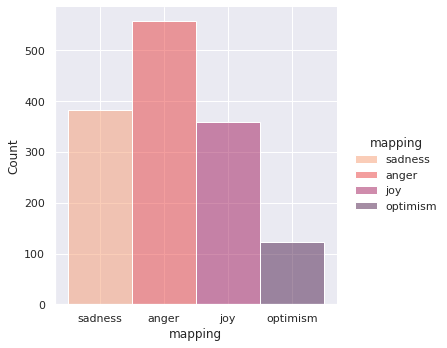

In [ ]:
#Exploration of 'Emotion Test Data'
sns.set_theme(style="darkgrid")
sns.displot(mapped_emotion_test, x='mapping', hue='mapping',palette='rocket_r')
print(mapped_emotion_test.mapping.value_counts())

anger       1400
sadness      855
joy          708
optimism     294
Name: mapping, dtype: int64


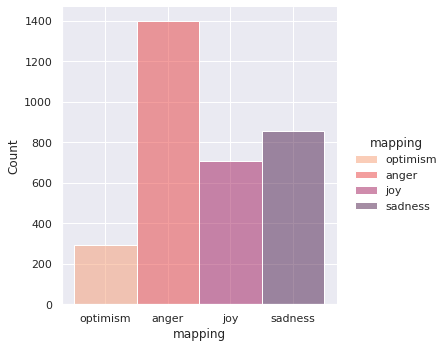

In [ ]:
#Exploration of 'Emotion Train Data'
sns.set_theme(style="darkgrid")
sns.displot(mapped_emotion_train, x='mapping', hue='mapping', palette='rocket_r')
print(mapped_emotion_train.mapping.value_counts())

anger       160
joy          97
sadness      89
optimism     28
Name: mapping, dtype: int64


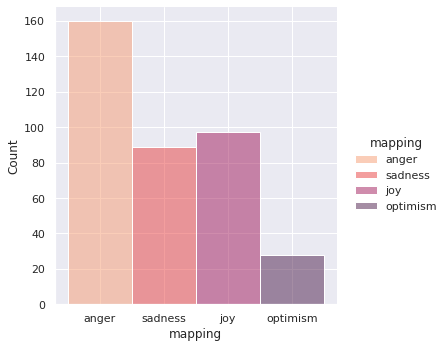

In [ ]:
#Exploration of 'Emotion Val Data'
sns.set_theme(style="darkgrid")
sns.displot(mapped_emotion_val, x='mapping', hue='mapping', palette='rocket_r')
print(mapped_emotion_val.mapping.value_counts())